# Packages: minimize for better structure

In [ ]:
!conda activate EEG_env
!conda install -c conda-forge mne
!conda install -c conda-forge matplotlib
!conda install -c conda-forge numpy
!conda install -c conda-forge pandas
!conda install -c conda-forge scipy
!conda install -c conda-forge scikit-learn
!conda install -c conda-forge seaborn

^C


In [1]:
!conda activate EEG_env

In [3]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
from matplotlib.ticker import FixedLocator
warnings.filterwarnings("ignore", category=UserWarning)



# Data initialization

In [5]:
full_path = 'C:\\Users\\RJEN0307\\Desktop\\Rasmus, Bachelorprojekt\\Data\\1_csv'

patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0] 
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)

    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})

    columns_to_remove = [col for col in data.columns if '_N' in col]
    data = data.drop(columns=columns_to_remove)

    resting_data = data[data['Event'] == 0]
    moving_data = data[data['Event'] == 1]
    familiar_data = data[data['Event'] == 2]
    target_count = min(moving_data.shape[0], familiar_data.shape[0])
    resting_data = resting_data.iloc[-target_count:]
    resting_data = resting_data.reset_index(drop=True)
    moving_data = moving_data.reset_index(drop=True)
    familiar_data = familiar_data.reset_index(drop=True)
    balanced_data = pd.concat([resting_data, moving_data, familiar_data]).reset_index(drop=True)

    standarize_list = ['PSD Delta', 'PSD Theta',  'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    #standarize_list =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']

    scaler = StandardScaler()
    balanced_data[standarize_list] = scaler.fit_transform(balanced_data[standarize_list])
    patient_data[patient_number] = balanced_data
    
    # show patient 10
    print(patient_data['p10'].head())

   Index  Event  PSD Delta  PSD Theta  PSD Alpha  PSD Beta  PSD Gamma  \
0   1500      0  -0.504771  -1.555079  -1.113242 -0.866272  -0.493307   
1   1501      0  -1.207551  -1.285578  -0.421632 -0.046604  -0.189003   
2   1502      0   2.094303  -0.218608  -0.972915 -1.282925  -0.468644   
3   1503      0   1.165314  -0.893731   0.395907 -1.449045  -1.025031   
4   1504      0  -0.710573  -0.297616  -1.010877 -0.883369  -1.267831   

     PSD SE   PSD MSF  PSD Sef90  PSD Sef95        PE      wSMI  Kolmogorov  \
0 -0.208458 -0.717660  -0.079449   0.452049 -0.135324 -0.296510    0.232978   
1  0.559548 -0.149165   0.738750   0.735636 -0.360464 -0.265355    0.580077   
2 -1.750320 -1.018849  -1.755760  -1.873936 -2.154975  0.022672   -0.688630   
3 -1.174411 -1.146854  -0.959331  -0.805472 -0.276526 -0.767685   -0.604848   
4  0.104931 -0.145400  -0.161088   0.230050 -0.436271 -0.012307    0.867331   

   Freq_Slope mean  Freq_Slope std  
0        -0.428410        0.710905  
1         1.

Most common number of PCA components explaining 95% variance: 8


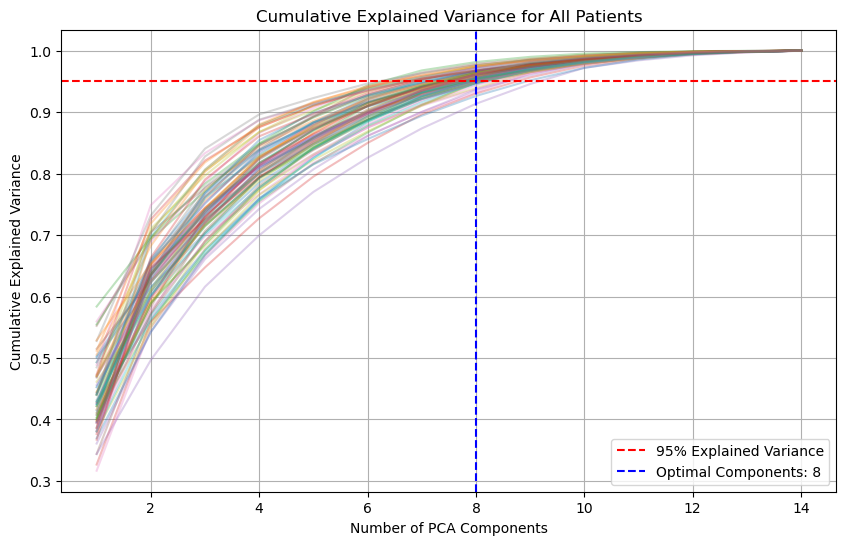

In [6]:
def find_optimal_pca_components(patient_data):
    component_counts = []
    cumulative_variances = []
    for patient, data in patient_data.items():
        features = data.drop(columns=['Index', 'Event'])

        pca = PCA()
        pca.fit(features)
        cumulative_variance = pca.explained_variance_ratio_.cumsum()
        cumulative_variances.append(cumulative_variance)
        n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
        component_counts.append(n_components)

    most_common_components = Counter(component_counts).most_common(1)[0][0]
    return most_common_components, component_counts, cumulative_variances

most_common_components, component_counts, cumulative_variances = find_optimal_pca_components(patient_data)
print(f"Most common number of PCA components explaining 95% variance: {most_common_components}")

plt.figure(figsize=(10, 6))
for cumulative_variance in cumulative_variances:
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, alpha=0.3)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for All Patients')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=most_common_components, color='b', linestyle='--', label=f'Optimal Components: {most_common_components}')
plt.grid()
plt.legend()
plt.show()



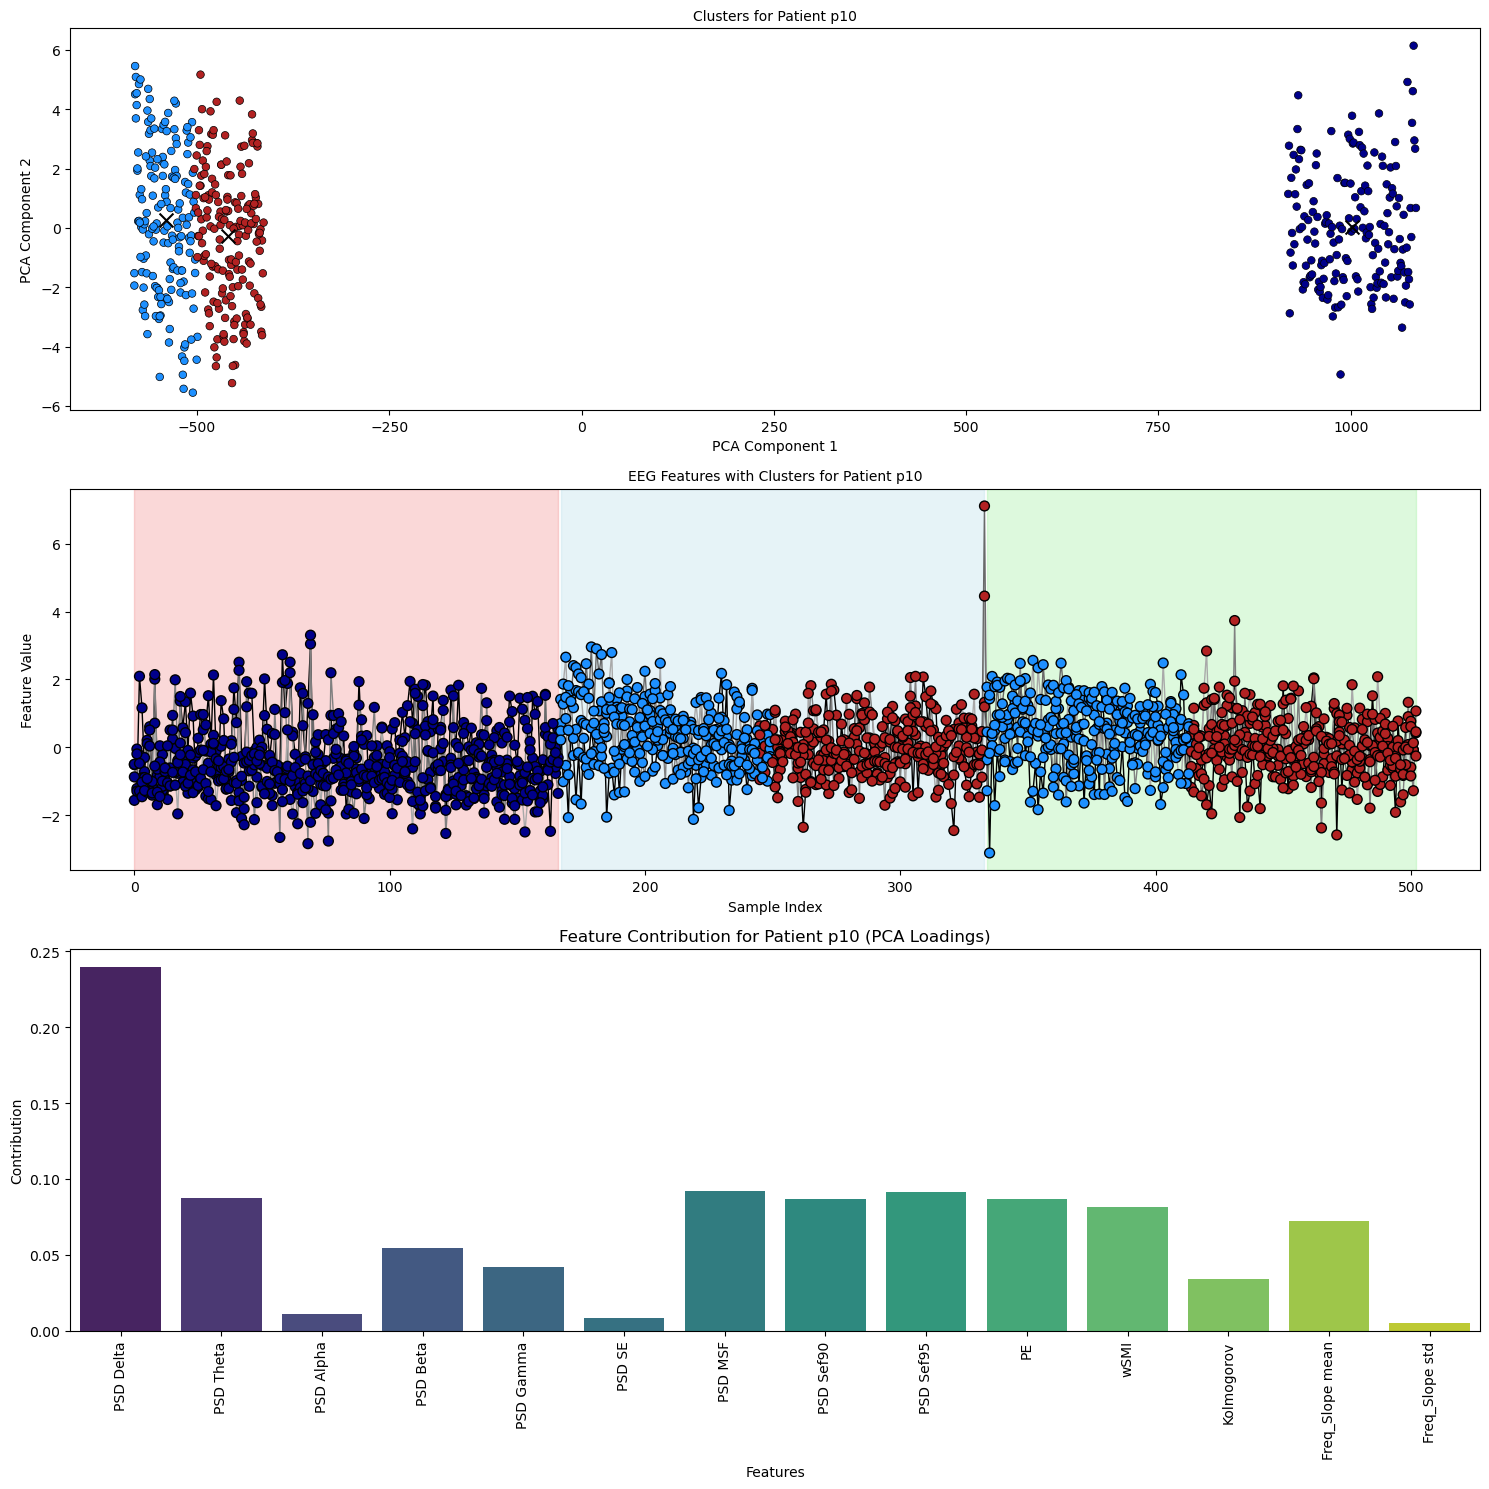

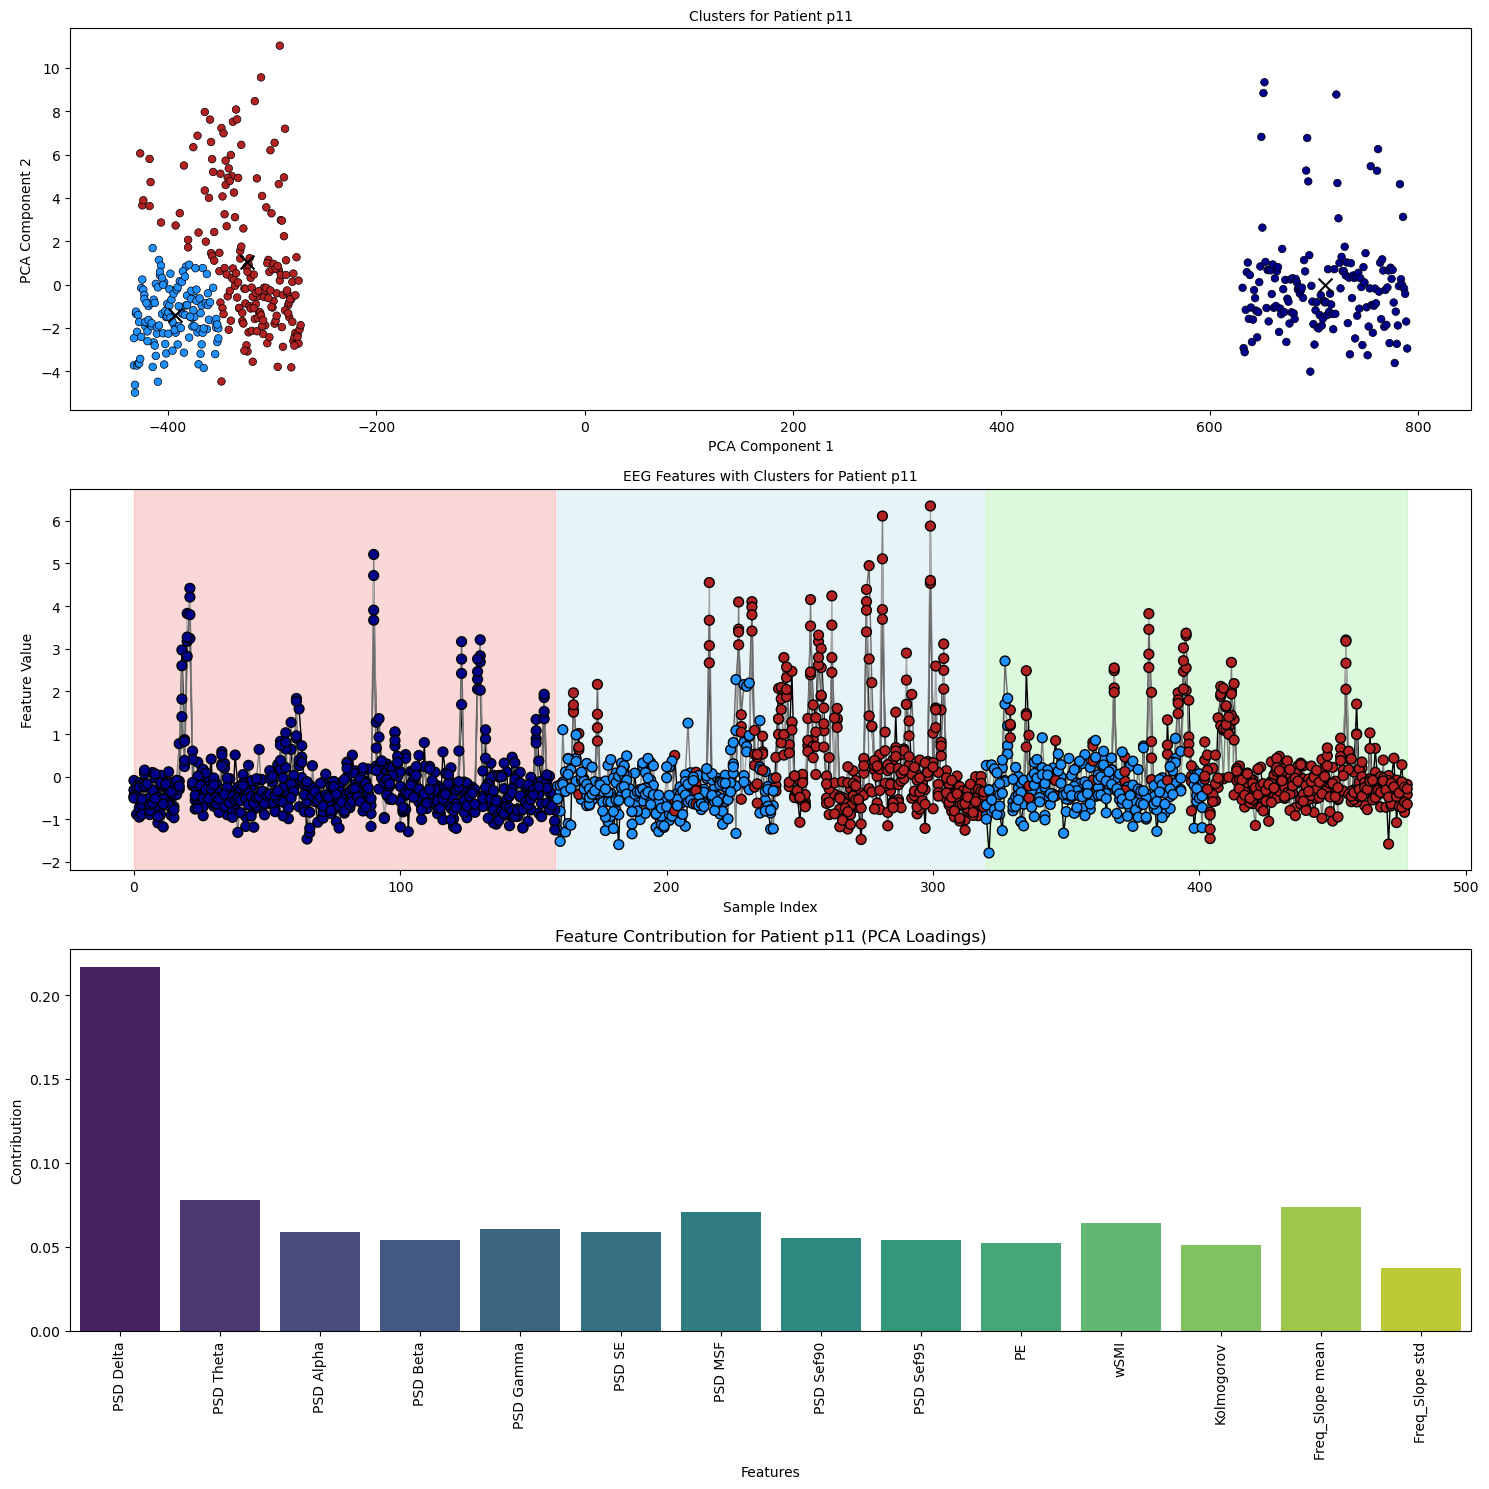

In [7]:
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf', contribution_pdf_path='feature_contribution_plot.pdf',output_pca_path = 'PCAplot_1',pca_plot = False,feature_importance=False):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    #feature_names =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    feature_importance_count = {feature: 0 for feature in feature_names}
    all_pca_data = []
    all_patient_labels = []

    
    for patient in patients:
        data = patient_data[patient].copy()

        data_for_pca = data.drop(columns=['Event'])

        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)
        pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components_pca)])

        all_pca_data.append(pca_df)
        all_patient_labels.extend([patient] * len(reduced_data))
        
        
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        feature_contributions = np.sum(np.abs(pca.components_[:2]), axis=0)
        feature_contributions /= np.sum(feature_contributions)

        if len(feature_contributions) != len(feature_names):
            feature_contributions = feature_contributions[:len(feature_names)]

        importance_threshold = np.percentile(feature_contributions, 75)

        for idx, contribution in enumerate(feature_contributions):
            if contribution >= importance_threshold:
                feature_importance_count[feature_names[idx]] += 1

        patient_data_with_labels = data.copy()
        patient_data_with_labels['Cluster Label'] = labels

        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        ax = axes[0]
        cluster_colors = ['firebrick' if label == 0 else 'darkblue' if label == 1 else 'dodgerblue' for label in labels]


        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
        ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', marker='x', label='Cluster Means')
        ax.set_title(f"Clusters for Patient {patient}", fontsize=10)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.grid(False)
        
        ax2 = axes[1]
        time = np.arange(len(patient_data_with_labels))
        
        ax2.plot(time, patient_data_with_labels['PSD Delta'], label='Delta (0.5-4 Hz)', color='black', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Theta'], label='Theta (4-8 Hz)', color='gray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Beta'], label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Gamma'], label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

        ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
        
        event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
        
        for _, group_data in patient_data_with_labels.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_idx = group_data.index[0]
                end_idx = group_data.index[-1]
                start_time = time[start_idx]
                end_time = time[end_idx]
                ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
        
        ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Feature Value')
        ax2.grid(False)

        ax3 = axes[2]
        sns.barplot(x=feature_names[:len(feature_contributions)], y=feature_contributions, palette='viridis', ax=ax3, hue=feature_names[:len(feature_contributions)], legend=False)
        ax3.xaxis.set_major_locator(FixedLocator(range(len(feature_names[:len(feature_contributions)]))))
        ax3.set_xticklabels(feature_names[:len(feature_contributions)], rotation=90)
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Contribution')
        ax3.set_title(f'Feature Contribution for Patient {patient} (PCA Loadings)')
        

        plt.tight_layout()
        
        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

    if feature_importance:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(feature_importance_count.keys()), y=list(feature_importance_count.values()), palette='viridis', hue=list(feature_importance_count.keys()), legend=False)

        plt.xlabel('Features')
        plt.ylabel('Count of Importance')
        plt.title('Feature Importance Count Across All Patients')
        plt.xticks(rotation=90)
        plt.tight_layout()

        if save_to_pdf:
            plt.savefig(contribution_pdf_path)
            plt.close()
        else:
            plt.show()
    else:
        plt.show()

    if pca_plot:
        combined_pca_df = pd.concat(all_pca_data, ignore_index=True)
        combined_pca_df['Patient'] = all_patient_labels
        pair_plot = sns.pairplot(combined_pca_df, hue='Patient', height=1.5, aspect=1, plot_kws={'s': 10}, diag_kind='hist')
        pair_plot._legend.remove()
        plt.suptitle("Combined PCA Pair Plot for All Patients", y=1.02)

        pca_image_path = output_pca_path.replace('.pdf', '_temp.png')
        pair_plot.savefig(pca_image_path, dpi=300, bbox_inches='tight')
        plt.show() 
        plt.close()

        if save_to_pdf:
            with PdfPages(output_pca_path) as pdf:
                img = plt.imread(pca_image_path)
                img_height, img_width = img.shape[0:2]
                fig, ax = plt.subplots(figsize=(img_width / 100, img_height / 100)) 
                ax.imshow(img)
                ax.axis('off') 
                pdf.savefig(fig, bbox_inches='tight') 
                plt.close(fig)

        if os.path.exists(pca_image_path):
            os.remove(pca_image_path)


patients = ['p10','p11']

# Example
combined_plot_for_each_patient(patient_data, patients, n_components_pca=2, n_components_gmm=3, feature_importance=False, pca_plot=False)

# Render and export all
#combined_plot_for_each_patient(patient_data, patients, n_components_pca=8, n_components_gmm=3, save_to_pdf=True, feature_importance=True, pca_plot=True, output_pdf_path='PDF files\\All features\\Patientplots_1.pdf', contribution_pdf_path='PDF files\\All features\\Featureplots_1.pdf',output_pca_path = 'PDF files\\All features\\PCAplots_1.pdf')
